# Создание чат-бота

В этом ноутбуке создадим чатбота на 3 интента:
- Простая болталка
- Вопросно-ответная система на медицинскую тематику (симптомы-диагноз)
- Поисковая система похожих отзывов на лекарства

Все необходимые сетки и поисковый индекс были обучены и сохранены в предыдущих ноутбуках

Установим необходимые зависимости:

In [1]:
! pip install -q transformers
! pip install annoy

     |████████████████████████████████| 5.3 MB 7.5 MB/s 
     |████████████████████████████████| 7.6 MB 48.0 MB/s 
     |████████████████████████████████| 163 kB 56.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 7.7 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=395172 sha256=3fd3240c73c7ddddf8306a3025e14034281f36ce310ec88dc9ea84fe1601749d
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [3]:
import numpy as np
import pandas as pd
import re
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification, AutoModelForCausalLM
import tensorflow as tf
import torch
import annoy

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
path =  "/content/drive/My Drive/GeekBrains/NLP/Course Project/"

Mounted at /content/drive/


Загрузим токенайзер и модель классификатора интентов:

In [5]:
tokenizer_intent_classifier = AutoTokenizer.from_pretrained(path + 'tokenizer_intent_classifier/')
model_intent_classifier = TFAutoModelForSequenceClassification.from_pretrained(path + 'model_intent_classifier/')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/GeekBrains/NLP/Course Project/model_intent_classifier/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Загрузим токенайзер и модель GPT для "болталки":

In [6]:
# device = torch.device("cuda")
device = torch.device("cpu")

In [7]:
tokenizer_dialog = AutoTokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')
model_dialog = AutoModelForCausalLM.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2').to(device)

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/551M [00:00<?, ?B/s]

Загрузим токенайзер и модель GPT для вопросно-ответной системы:

In [8]:
tokenizer_qa_medical_gen = AutoTokenizer.from_pretrained(path + 'tokenizer_qa_medical_gen')
model_qa_medical_gen = AutoModelForCausalLM.from_pretrained(path + 'model_qa_medical_gen').to(device)

Загрузим токенайзер и модель для получения эмбеддинга отзыва на лекарство:

In [9]:
model_embedding = TFAutoModel.from_pretrained("Geotrend/bert-base-ru-cased")
tokenizer_embedding = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")

Downloading:   0%|          | 0.00/659 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/133k [00:00<?, ?B/s]

Загрузим поисковый индекс:

In [10]:
index = annoy.AnnoyIndex(768 ,'angular')
index.load(path + 'index.ann')

True

Загрузим датасет с отзывами:

In [11]:
data = pd.read_csv(path + 'drugs_feedback.csv')
data = data.text

Напишем класс для диалоговой системы DialogSystem.

**Почему класс, а не функция?**

Дело в том, что telegram python api работает следующим образом:
- Ожидает отправки сообщения пользователем
- Получив сообщение, передает управление внешней функции, которая генерирует ответ и отправляет его во внутреннюю api-функцию
- Отправив ответ в telegram, api переходит в режим ожидания.

Если сделать просто внешнюю функцию, она будет на каждое сообщение пользователя вызываться заново и не сможет хранить контекст разговора. Поэтому было принято решение написать класс, в котором один из атрибутов объекта класса - это список истории сообщений (контекст разговора). Внешней функцией при этом будет метод объекта класса. При новом вызове этого метода история сообщений теряться не будет.

**Основные методы объекта класса DialogSystem:**
- intent_classifier - классифицирует входящее сообщение на 3 интента. Если текущий интент меняется, обнуляет историю сообщений.
- dialog_generator - генерирует ответы для двух интентов - болталки и медицинской вопросно-ответной системы. При разных интентах на вход подаются разные GPT-модели
- search_article - поиск 3-х наиболее подходящих отзывов в ответ на сообщение. Для 3-го интента
- Объединяет все эти методы метод get_response. Именно он и будет вызываться как внешняя функция.
- Также в классе есть вспомогательные функции для выполнения принципа DRY (Don't Repeat Yourself)


In [12]:
class DialogSystem:


    def __init__(self,
                 tokenizer_intent_classifier,
                 model_intent_classifier,
                 tokenizer_dialog,
                 model_dialog,
                 tokenizer_qa_medical_gen,
                 model_qa_medical_gen,
                 model_embedding,
                 tokenizer_embedding,
                 index,
                 data,
                 lenght_history = 10):
        self.context = [] # Список, хранящий lenght_history предыдущих сообщений
        self.current_intent = 0 # Текущий интент. При изменении интента обнуляется self.context
        self.tokenizer_intent_classifier = tokenizer_intent_classifier
        self.model_intent_classifier = model_intent_classifier
        self.tokenizer_dialog = tokenizer_dialog
        self.model_dialog = model_dialog
        self.tokenizer_qa_medical_gen = tokenizer_qa_medical_gen
        self.model_qa_medical_gen = model_qa_medical_gen
        self.model_embedding = model_embedding
        self.tokenizer_embedding = tokenizer_embedding
        self.index = index
        self.data = data
        self.lenght_history = lenght_history
    

    def intent_classifier(self, sentence):
        sent_token = self.tokenizer_intent_classifier(sentence, padding="max_length", truncation=True, return_tensors='tf')
        predict_intent = self.model_intent_classifier(sent_token).logits.numpy().argmax()
        if predict_intent != self.current_intent:
            self.context = []
        self.current_intent = predict_intent
        print(f'current intent: {predict_intent}')
        return predict_intent
    

    def custom_append(self, a, b):
        a.append(b)
        if len(a) > self.lenght_history:
            a.pop(0)
    

    def respond_to_dialog(self, model, tokenizer, texts):
        prefix = '\nx:'
        for i, t in enumerate(texts):
            prefix += t
            prefix += '\nx:' if i % 2 == 1 else '\ny:'
        tokens = tokenizer(prefix, return_tensors='pt')
        tokens = {k: v.to(model.device) for k, v in tokens.items()}
        end_token_id = tokenizer.encode('\n')[0]
        size = tokens['input_ids'].shape[1]
        output = model.generate(
            **tokens, 
            eos_token_id=end_token_id,
            do_sample=True, 
            max_length=size+128, 
            repetition_penalty=3.2, 
            temperature=1,
            num_beams=3,
            length_penalty=0.01,
            pad_token_id=tokenizer.eos_token_id
        )
        decoded = tokenizer.decode(output[0])
        result = re.findall(r'\ny:(.+)', decoded)[-1] 
        return result.strip()


    def dialog_generator(self, model, tokenizer, sentence):
        self.custom_append(self.context, sentence)
        result = self.respond_to_dialog(model, tokenizer, self.context)
        self.custom_append(self.context, result)
        return result
    

    def search_article(self, sentence):
        tokens = self.tokenizer_embedding(sentence,
                                         max_length=512,
                                         truncation=True,
                                         padding='max_length',
                                         return_token_type_ids=False,
                                         return_tensors='tf')
        vector = self.model_embedding(**tokens).pooler_output[0]
        index_val = index.get_nns_by_vector(vector, 3)
        res = self.data.iloc[index_val].tolist()
        return res
    

    def get_response(self, sentence):
        predict_intent = self.intent_classifier(sentence)
        if predict_intent == 0:
            res = self.dialog_generator(self.model_dialog, self.tokenizer_dialog, sentence)
        elif predict_intent == 1:
            res = self.dialog_generator(self.model_qa_medical_gen, self.tokenizer_qa_medical_gen, sentence)
        else:
            res = self.search_article(sentence)
        return res



Создадим объект responser класса DialogSystem:

In [13]:
responser = DialogSystem(tokenizer_intent_classifier,
                         model_intent_classifier,
                         tokenizer_dialog,
                         model_dialog,
                         tokenizer_qa_medical_gen,
                         model_qa_medical_gen,
                         model_embedding,
                         tokenizer_embedding,
                         index,
                         data)

Создадим тестовую функцию, аналогичную callback-функции в MessageHandler, чтобы протестировать работу нашей диалоговой системы, не подключаясь к api telegram:

In [22]:
def test_text_message():
    message = input()
    answer = responser.get_response(message)
    if answer.__class__.__name__ == 'list': # 3-й интент выдает список из трех отзывов, поэтому выводим на печать каждый по очереди
        for itm in answer:
            print(itm)
    else:
        print(answer)

Создадим бесконечный цикл с вызовом тестовой функции:

In [23]:
while True:
    test_text_message()

Привет!)
current intent: 0
Здравствуйте)
Как дела?)
current intent: 0
Всё ок!
Что делаешь?)
current intent: 0
Работаю))
Я тоже) Посоветуй какой-нибудь фильм посмотреть)
current intent: 0
Какой?
Боевик)
current intent: 0
Нет, не могу ничего посоветовать.
Ладно, переключимся на доктора. У меня болит горло, что мне делать?
current intent: 1
Здравствуйте! Обратитесь к ЛОР врачу-терапевту. Возможно потребуется госпитализация в стационар. По переписке лечение не назначается. Выполните рентген органов грудной клетки с контрастированием. При необходимости - сдайте кровь на гормоны щитовидной железы (ТТГ). В зависимости от локализации и степени выраженности болевого синдрома выполните ЭЭГ. Покажитесь терапевту. Сдайте общий анализ крови, мочи, биохимический анализ крови. Выполните флюорографию органов грудной клетки. Необходим осмотр пульмонолога для уточнения диагноза. Удачи Вам!
А какие лекарства можно принимать, если болит горло?
current intent: 1
Попробуйте Циклоферон или Ибупрофен. Это наи

KeyboardInterrupt: ignored

Что могу сказать по ведению диалога ботом - когда я начинал работать над проектом, я не ожидал, что бот будет работать настолько хорошо =)

## Создание telegram-bot
Приступим к созданию собственно telegram-бота

In [34]:
!pip install python-telegram-bot==13.8 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached python_telegram_bot-13.8-py3-none-any.whl (495 kB)
     |████████████████████████████████| 500 kB 5.4 MB/s 
     |████████████████████████████████| 161 kB 68.1 MB/s 
  Using cached cachetools-4.2.2-py3-none-any.whl (11 kB)
  Using cached APScheduler-3.6.3-py2.py3-none-any.whl (58 kB)
  Using cached tornado-6.2-cp37-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (423 kB)
     |████████████████████████████████| 1.2 MB 57.8 MB/s 
     |████████████████████████████████| 70 kB 9.3 MB/s 
     |████████████████████████████████| 336 kB 50.6 MB/s 
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 1.5.1
    Uninstalling tzlocal-1.5.1:
      Successfully uninstalled tzlocal-1.5.1
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.

In [35]:
! pip install tornado==5.1.0 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tornado-5.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: tornado
    Found existing installation: tornado 6.2
    Uninstalling tornado-6.2:
      Successfully uninstalled tornado-6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-telegram-bot 13.8 requires tornado>=6.1, but you have tornado 5.1 which is incompatible.


In [41]:
from telegram import Update
from telegram.ext  import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

In [42]:
updater = Updater(token='5472186038:AAGd5nvwzuMnMWHzLrybAHaPUnWE3oyqCIU') # Токен API к Telegram
dispatcher = updater.dispatcher

def startCommand(update: Update, context: CallbackContext):
    text = 'Добрый день!\nВас приветствует бот MedDialog!\nС ним вы можете просто поболтать на отвлеченную тематику, получить консультацию экспертной медицинской системы, а также получить отзывы на интересующие вас лекарства'
    update.message.reply_text(text)

def textMessage(update: Update, context: CallbackContext):
    input_txt = update.message.text
    answer = responser.get_response(input_txt)
    if answer.__class__.__name__ == 'list': # 3-й интент выдает список из трех отзывов, поэтому выводим на печать каждый по очереди
        for itm in answer:
            update.message.reply_text(itm)
    else:
        update.message.reply_text(answer)

start_command_handler = CommandHandler('start', startCommand)
text_message_handler = MessageHandler(Filters.text, textMessage)
dispatcher.add_handler(start_command_handler)
dispatcher.add_handler(text_message_handler)
updater.start_polling(clean=True)
updater.idle()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TelegramDeprecationWarning: The argument `clean` of `start_polling` is deprecated. Please use `drop_pending_updates` instead.


current intent: 0
current intent: 0
current intent: 0
current intent: 0
current intent: 1
current intent: 1
current intent: 1
current intent: 2
current intent: 2


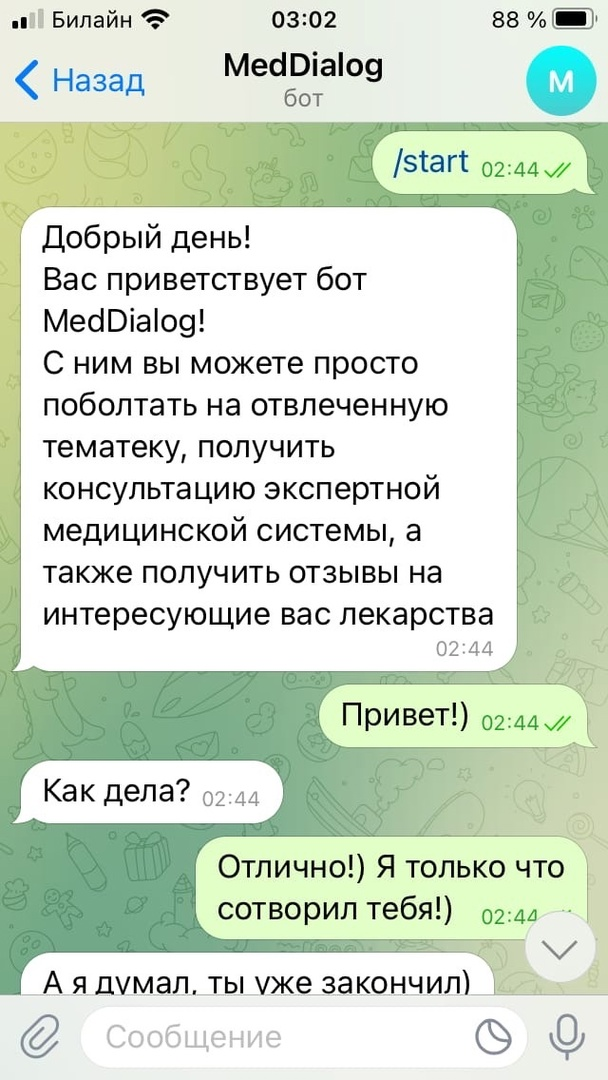

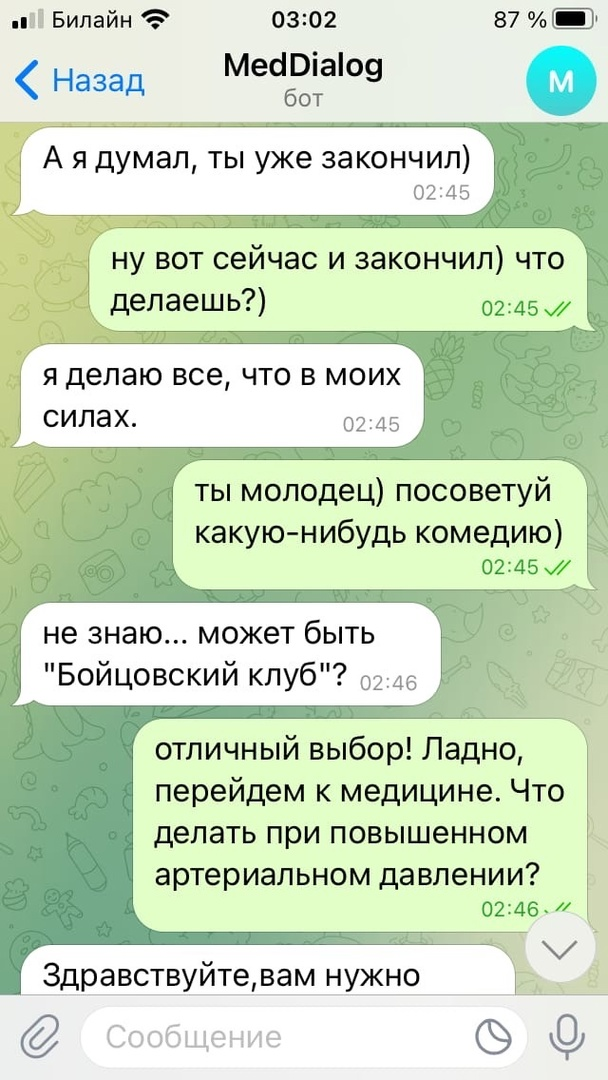

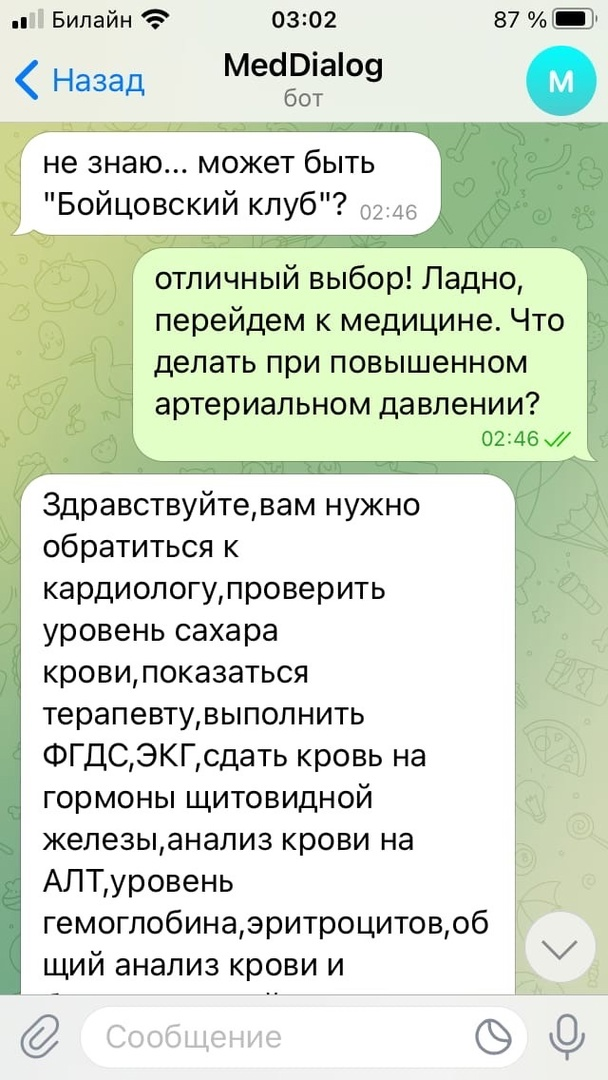

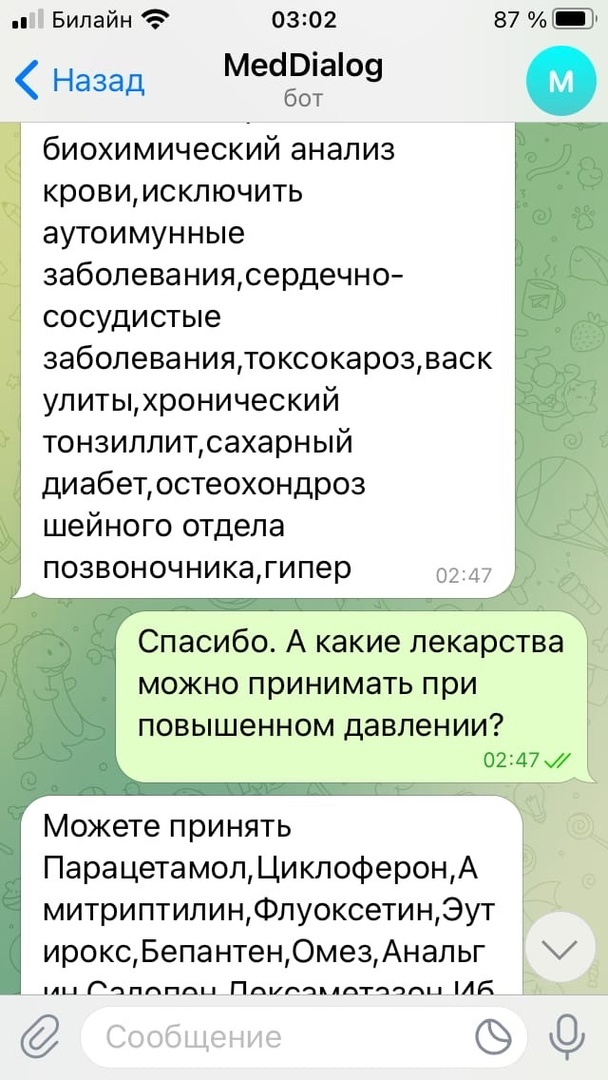

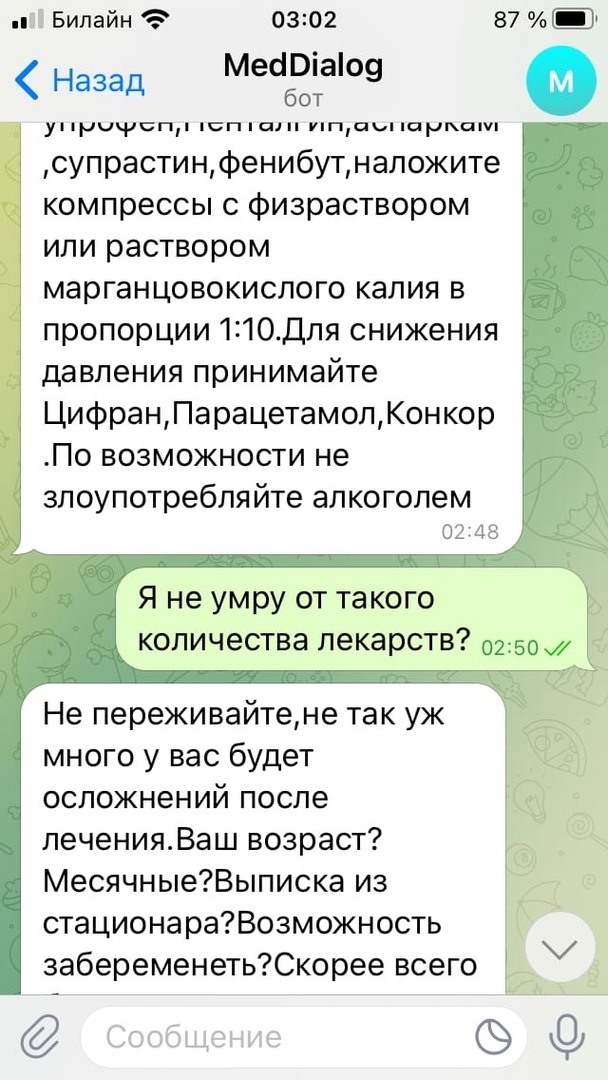

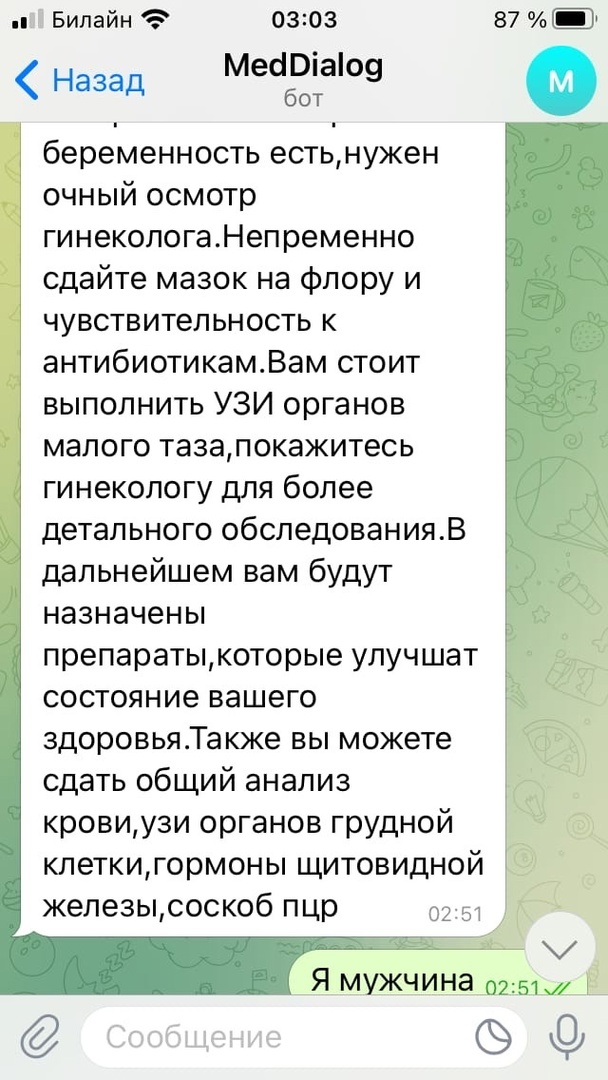

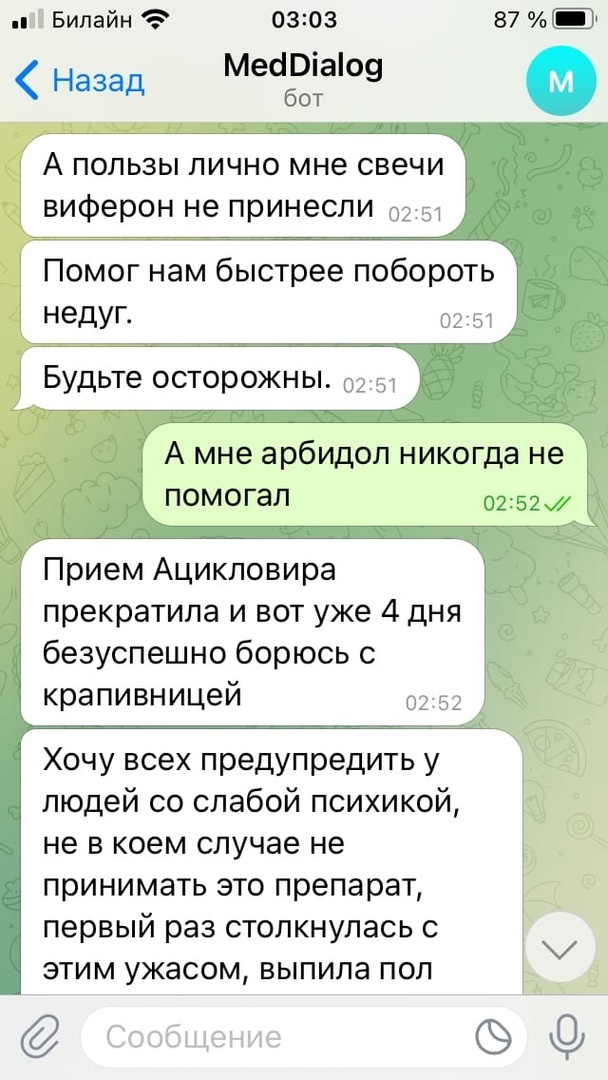

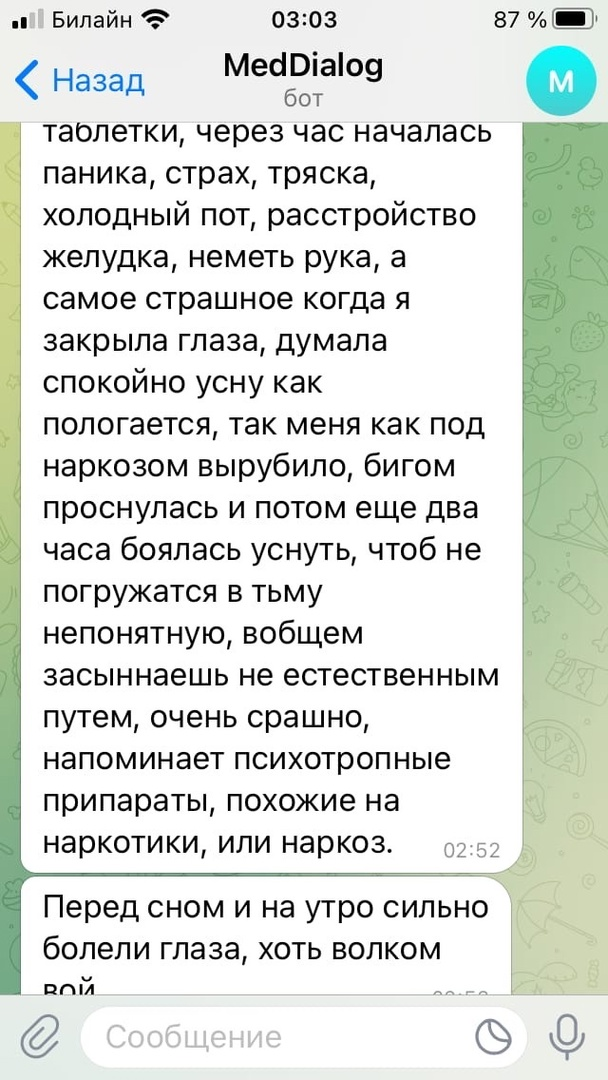

**Все отлично работает!**